# 휘발유와 경유 가격은 셀프 주유소에서 정말 저렴할까?
주유소 분석을 위한 지역은 서울로 제한을 한다.

## 문제1. 서울시 구별 주유소 데이터 정보 크롤링
- https://www.opinet.co.kr/searRgSelect.do
- 목표
    - 수집한 데이터들을 pandas 데이터프레임으로 정리 
    - 부가 정보 데이터 : Y 또는 N 으로 저장
    - 컬럼 이름은 영문으로 작성
- 수집 데이터
    - 주유소명(StationName)
    - 주소(Address)
    - 브랜드(Brand)
    - 휘발유 가격(GasolinePrice)
    - 경유 가격(DieselPrice)
    - 셀프 여부(SelfService)
    - 세차장 여부(CarWash)
    - 충전소 여부(ChargingStation)
    - 경정비 여부(Maintenance)
    - 편의점 여부(ConvenienceStore)
    - 24시간 운영 여부(Open24Hours)
    - 구(Gu)
    - 위도(Latitude)
    - 경도(Longitude)

In [43]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument("start-maximized")

In [44]:
url = 'https://www.opinet.co.kr/searRgSelect.do'
driver = webdriver.Chrome(options=options)
driver.get(url)

### 부가정보(세차장, 경정비, 편의점, 24시간) 선택

#### 세차장

In [45]:
def check_car_wash_btn():
    car_wash_btn = driver.find_element(By.CSS_SELECTOR, '#CWSH_YN')
    if not car_wash_btn.is_selected():
        car_wash_btn.click()
check_car_wash_btn()

#### 경정비

In [46]:
def check_maintainance_btn():
    maintainance_btn = driver.find_element(By.CSS_SELECTOR, '#MAINT_YN')
    if not maintainance_btn.is_selected():
        maintainance_btn.click()
check_maintainance_btn()

#### 편의점

In [47]:
def check_conve_store_btn():
    conve_store_btn = driver.find_element(By.CSS_SELECTOR, '#CVS_YN')
    if not conve_store_btn.is_selected():
        conve_store_btn.click()
check_conve_store_btn()

#### 24시간

In [48]:
def check_24hours_btn():
    hours_btn = driver.find_element(By.CSS_SELECTOR, '#SEL24_YN')
    if not hours_btn.is_selected():
        hours_btn.click()
check_24hours_btn()

### '서울시' 선택

In [49]:
sido_list_raw = driver.find_element(By.ID, 'SIDO_NM0')
sido_list = sido_list_raw.find_elements(By.TAG_NAME, 'option')

sido_names = []

for option in sido_list:
    if option.text != '시/도':
        sido_names.append(option.get_attribute("value"))

sido_list_raw.send_keys(sido_names[0])

### 지역: 구 리스트 추출

In [50]:
gu_list_raw = driver.find_element(By.ID, 'SIGUNGU_NM0')
gu_list_raw.text

'시/군/구\n강남구\n강동구\n강북구\n강서구\n관악구\n광진구\n구로구\n금천구\n노원구\n도봉구\n동대문구\n동작구\n마포구\n서대문구\n서초구\n성동구\n성북구\n송파구\n양천구\n영등포구\n용산구\n은평구\n종로구\n중구\n중랑구'

In [51]:
gu_list = gu_list_raw.find_elements(By.TAG_NAME, 'option')
gu_list[0].text, gu_list[1].text

('시/군/구', '강남구')

In [52]:
gu_names = []

for option in gu_list:
    if option.text != '시/군/구':
        gu_names.append(option.get_attribute('value'))

gu_names

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

In [56]:
gu_list_raw = driver.find_element(By.ID, 'SIGUNGU_NM0')
gu_list_raw.send_keys(gu_names[3])

### 지역: 구 데이터 모두 수집

In [72]:
import time
from bs4 import BeautifulSoup

station_name = []
address = []
brand = []
gasoline_price = []
diesel_price = []
self_service = []
car_wash = []
charging_station = []
maintainance = []
cvs = []
open_24hours = []
gu = []

for gu_name in gu_names:
    # 구선택
    gu_list_raw = driver.find_element(By.ID, 'SIGUNGU_NM0')
    gu_list_raw.send_keys(gu_name)
    time.sleep(5)
    
    soup = BeautifulSoup(driver.page_source, "html.parser")
    datas = soup.select('#body1 > tr')
    
    for i in range(0, len(datas)):
        # 셀프주유 여부
        service_tag = datas[i].select_one('.ico')
        tmp = None if service_tag == None else service_tag.text
        self_service.append('Y' if tmp == '셀프' else 'N')

        # 휘발유 가격
        gasoline_price.append(datas[i].select('.price')[0].text.strip())
        
        # 경유 가격
        diesel_price.append(datas[i].select('.price')[1].text.strip())
        
        # 브랜드
        brand.append(datas[i].select_one('.rlist > img')['alt'])
        
        # 요소 클릭(팝업 데이터 이용 위함)
        driver.find_element(By.XPATH, '//*[@id="body1"]/tr['+ str(i+1) +']/td[1]/a').click() 
        time.sleep(5)
        
        # 팝업 html
        soup = BeautifulSoup(driver.page_source, "html.parser")
        station_info = soup.select_one('#os_dtail_info > div.inner')
        
        # 주유소명
        station_name.append(station_info.select_one('.inner > .header > label').text)
                   
        # 주소
        address.append(station_info.select_one('#rd_addr').text)
                   
        # 구
        gu.append(address[-1].split()[1])
                   
        # 세차장 여부
        car_wash.append('N' if 'off' in station_info.select_one('#cwsh_yn')['src'] else 'Y')
                   
        # 충전소 여부
        charging_station.append('N' if 'off' in station_info.select_one('#lpg_yn')['src'] else 'Y')
                   
        # 경정비 여부
        maintainance.append('N' if 'off' in station_info.select_one('#maint_yn')['src'] else 'Y')
                   
        # 편의점 여부
        cvs.append('N' if 'off' in station_info.select_one('#cvs_yn')['src'] else 'Y')
        
        # 24시간 운영 여부
        open_24hours.append('N' if 'off' in station_info.select_one('#sel24_yn')['src'] else 'Y')

In [73]:
len(station_name), len(address), len(brand), len(gasoline_price), len(diesel_price), len(self_service), 
len(car_wash), len(charging_station), len(maintainance), len(cvs), len(open_24hours), len(gu)

(355, 355, 355, 355, 355, 355)

In [74]:
import pandas as pd

df = pd.DataFrame({
    "station_name" : station_name,
    "address": address,
    "brand": brand,
    "gasoline_price": gasoline_price,
    "diesel_price": diesel_price,
    "self_service": self_service,
    "car_wash": car_wash,
    "charging_station": charging_station,
    "maintainance": maintainance,
    "cvs": cvs,
    "open_24hours": open_24hours,
    "gu": gu
})
df.head()

,station_name,address,brand,gasoline_price,diesel_price,self_service,car_wash,charging_station,maintainance,cvs,open_24hours,gu
0,HD현대오일뱅크㈜직영 강남셀프주유소,서울 강남구 도곡로 208,HD현대오일뱅크,1699,1599,Y,Y,N,N,N,N,강남구
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,1709,1578,Y,Y,N,N,N,N,강남구
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,1717,1599,Y,Y,N,N,N,N,강남구
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,1717,1578,Y,Y,N,N,N,N,강남구
4,자곡셀프주유소,서울 강남구 밤고개로 120 (자곡동),SK에너지,1717,1599,Y,Y,N,N,N,N,강남구


In [78]:
driver.close()

### 엑셀에 저장

In [75]:
df.to_csv("./data/station", sep=",", encoding="utf-8")

## 문제2. 분석 및 분석 결과

### 데이터 가져옴

In [77]:
df = pd.read_csv("./data/station", encoding="utf-8", index_col=0)
df.head()

,station_name,address,brand,gasoline_price,diesel_price,self_service,car_wash,charging_station,maintainance,cvs,open_24hours,gu
0,HD현대오일뱅크㈜직영 강남셀프주유소,서울 강남구 도곡로 208,HD현대오일뱅크,1699,1599,Y,Y,N,N,N,N,강남구
1,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,1709,1578,Y,Y,N,N,N,N,강남구
2,방죽주유소,서울 강남구 밤고개로 215 (율현동),GS칼텍스,1717,1599,Y,Y,N,N,N,N,강남구
3,HD현대오일뱅크㈜직영 산성셀프주유소,서울 강남구 헌릉로 730,HD현대오일뱅크,1717,1578,Y,Y,N,N,N,N,강남구
4,자곡셀프주유소,서울 강남구 밤고개로 120 (자곡동),SK에너지,1717,1599,Y,Y,N,N,N,N,강남구


### 휘발유 boxplot

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

f_path = "/Library/Fonts/Arial Unicode.ttf"
family = font_manager.FontProperties(fname=f_path).get_name()
rc("font", family=family)

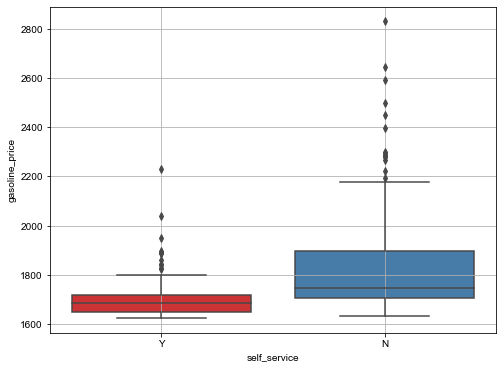

In [80]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="self_service", y="gasoline_price", data=df, palette="Set1")
plt.grid(True)
plt.show()

### 경유 boxplot

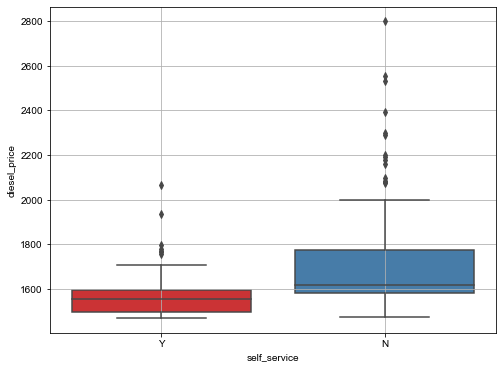

In [81]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="self_service", y="diesel_price", data=df, palette="Set1")
plt.grid(True)
plt.show()

### 구별 휘발유 셀프 비교 막대그래프

In [99]:
import numpy as np

gu_data = pd.pivot_table(
    data=df, 
    index="gu", 
    columns="self_service",
    values=["gasoline_price", "diesel_price"], 
    aggfunc=np.median
)

gu_data.head()

diesel_price         gasoline_price        
self_service            N       Y              N       Y
gu                                                      
강남구                2076.0  1642.0         2266.0  1780.5
강동구                1743.5  1638.5         1855.0  1763.0
강북구                1519.0  1475.0         1679.0  1625.0
강서구                1603.5  1549.0         1733.0  1686.0
관악구                1606.5  1579.0         1738.5  1719.0

In [87]:
gu_data.columns

MultiIndex([(  'diesel_price', 'N'),
            (  'diesel_price', 'Y'),
            ('gasoline_price', 'N'),
            ('gasoline_price', 'Y')],
           names=[None, 'self_service'])

In [98]:
df[df["gu"]=="은평구"]

,station_name,address,brand,gasoline_price,diesel_price,self_service,car_wash,charging_station,maintainance,cvs,open_24hours,gu
320,(주)아이에스피에너지(서울서부고속주유소),서울 은평구 응암로 163,HD현대오일뱅크,1647,1484,Y,N,N,N,N,Y,은평구
321,타이거주유소,서울 은평구 수색로 188 (증산동),SK에너지,1649,1524,Y,Y,N,N,N,N,은평구
322,지에스칼텍스(주)수색뉴타운주유소,서울 은평구 수색로 350 (수색동),GS칼텍스,1659,1534,Y,Y,N,N,N,N,은평구
323,(주)디오티디 은평유니콘주유소,서울 은평구 통일로 1151 (진관동),HD현대오일뱅크,1659,1489,N,Y,N,N,N,N,은평구
324,불광주유소,서울 은평구 연서로 314 (불광동),HD현대오일뱅크,1667,1535,Y,Y,N,N,N,N,은평구
325,지에스칼텍스㈜ 서부주유소,서울 은평구 응암로 210 (응암동),GS칼텍스,1667,1564,Y,Y,N,Y,N,N,은평구
326,지에스칼텍스㈜ 신사제일주유소,서울 은평구 증산로 423 (신사동),GS칼텍스,1669,1564,Y,Y,N,N,N,Y,은평구
327,대성산업㈜ 대성주유소,서울 은평구 통일로 642,GS칼텍스,1675,1545,Y,Y,N,N,N,Y,은평구
328,은평뉴타운주유소,서울 은평구 통일로 924 (불광동),SK에너지,1695,1558,Y,Y,N,Y,N,N,은평구
329,박석고개주유소,서울 은평구 통일로 945 (갈현동),SK에너지,1695,1558,Y,Y,N,N,N,Y,은평구


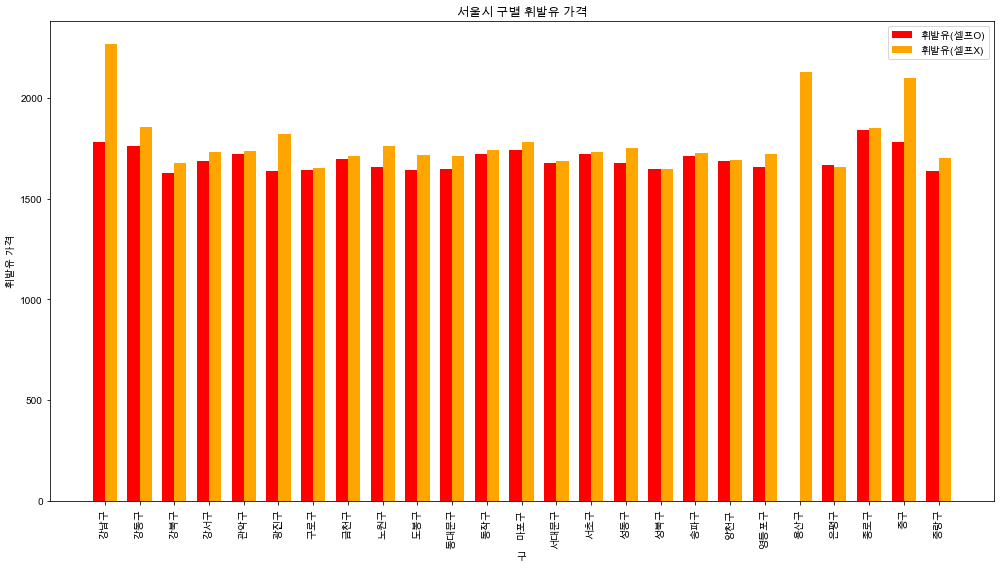

In [100]:
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = range(len(gu_data))

bar1 = plt.bar(index, gu_data['gasoline_price', 'Y'], bar_width, label='휘발유(셀프O)', color="red")
bar2 = plt.bar([i + bar_width for i in index], gu_data['gasoline_price', 'N'], bar_width, label='휘발유(셀프X)', color="orange")

plt.xlabel('구')
plt.ylabel('휘발유 가격')
plt.title('서울시 구별 휘발유 가격')
plt.xticks([i + bar_width / 2 for i in index], gu_data.index, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

### 구별 경유 셀프 비교 막대그래프

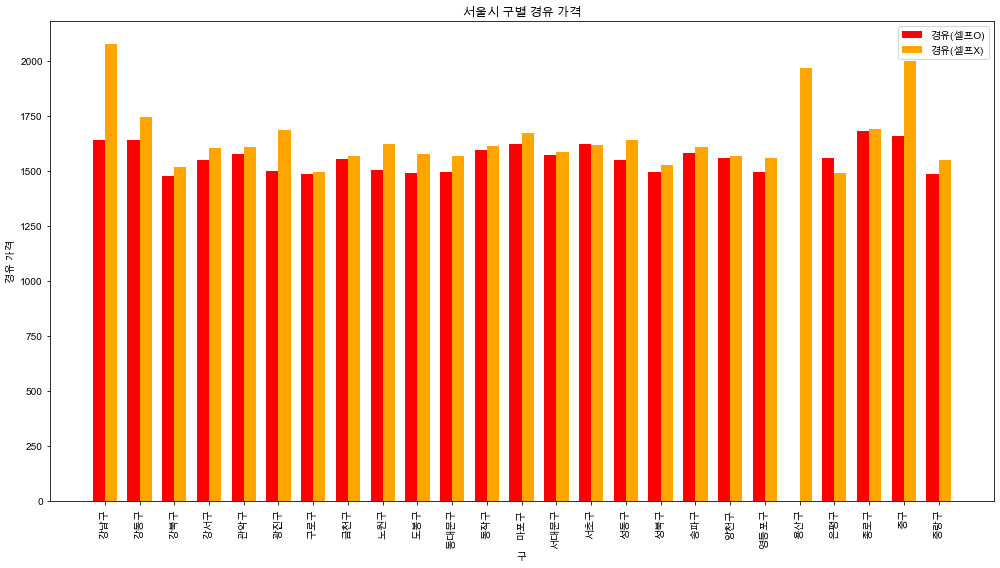

In [101]:
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = range(len(gu_data))

bar1 = plt.bar(index, gu_data['diesel_price', 'Y'], bar_width, label='경유(셀프O)', color="red")
bar2 = plt.bar([i + bar_width for i in index], gu_data['diesel_price', 'N'], bar_width, label='경유(셀프X)', color="orange")

plt.xlabel('구')
plt.ylabel('경유 가격')
plt.title('서울시 구별 경유 가격')
plt.xticks([i + bar_width / 2 for i in index], gu_data.index, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

### 브랜드별 휘발유 셀프 비교 막대 그래프

In [102]:
import numpy as np

brand_data = pd.pivot_table(
    data=df, 
    index="brand", 
    columns="self_service",
    values=["gasoline_price", "diesel_price"], 
    aggfunc=np.median
)

brand_data.head()

diesel_price         gasoline_price        
self_service            N       Y              N       Y
brand                                                   
GS칼텍스              1635.0  1563.5         1758.0  1686.0
HD현대오일뱅크           1608.0  1527.0         1720.0  1668.5
S-OIL              1672.0  1546.5         1801.5  1693.0
SK에너지              1680.5  1577.0         1788.0  1709.0
알뜰                 1608.0  1518.5         1736.0  1668.5

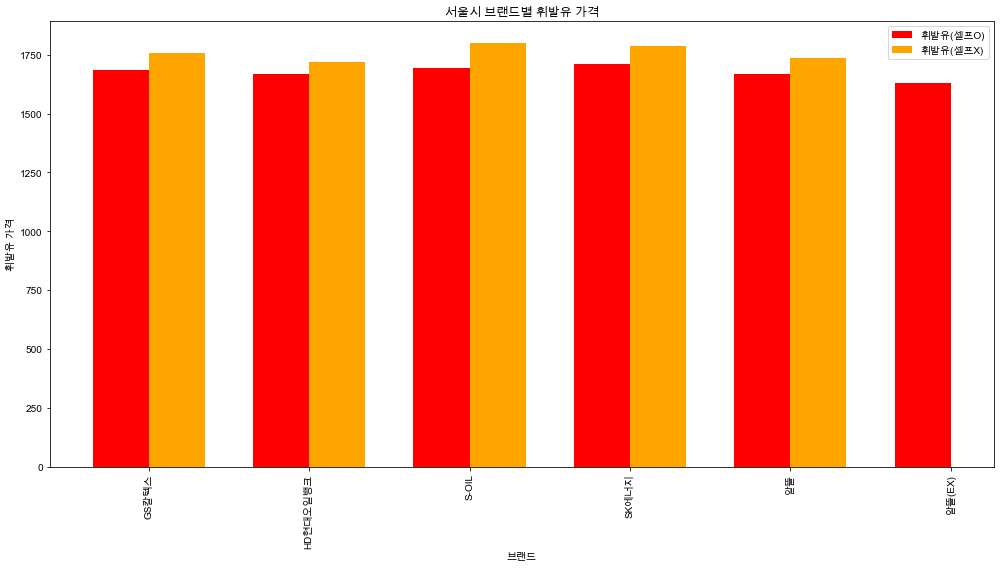

In [103]:
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = range(len(brand_data))

bar1 = plt.bar(index, brand_data['gasoline_price', 'Y'], bar_width, label='휘발유(셀프O)', color="red")
bar2 = plt.bar([i + bar_width for i in index], brand_data['gasoline_price', 'N'], bar_width, label='휘발유(셀프X)', color="orange")

plt.xlabel('브랜드')
plt.ylabel('휘발유 가격')
plt.title('서울시 브랜드별 휘발유 가격')
plt.xticks([i + bar_width / 2 for i in index], brand_data.index, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

### 브랜드별 경유 셀프 비교 막대 그래프

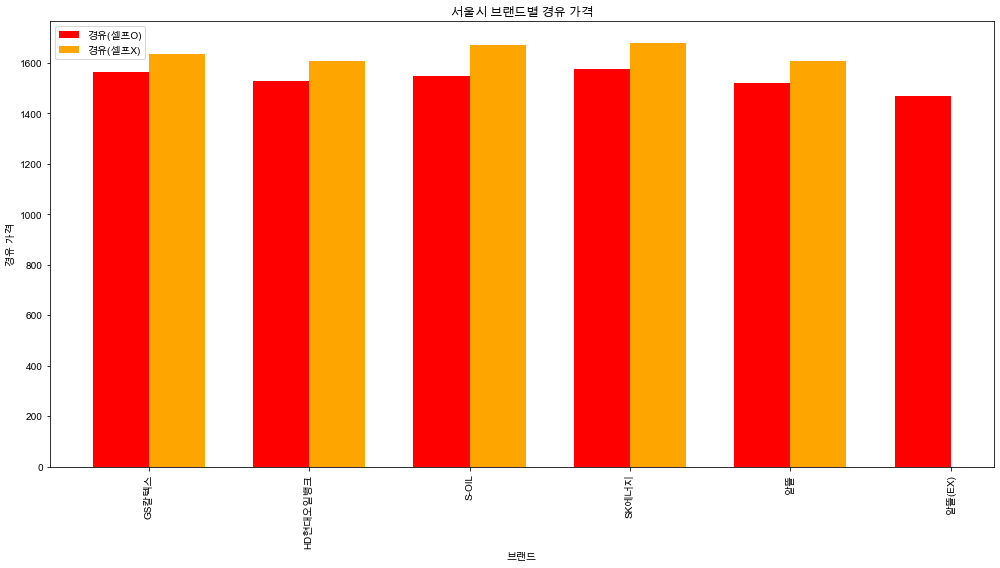

In [95]:
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = range(len(brand_data))

bar1 = plt.bar(index, brand_data['diesel_price', 'Y'], bar_width, label='경유(셀프O)', color="red")
bar2 = plt.bar([i + bar_width for i in index], brand_data['diesel_price', 'N'], bar_width, label='경유(셀프X)', color="orange")

plt.xlabel('브랜드')
plt.ylabel('경유 가격')
plt.title('서울시 브랜드별 경유 가격')
plt.xticks([i + bar_width / 2 for i in index], brand_data.index, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

<a id="구별-매장-수-막대-그래프"></a>

<a id="구별-매장-분포도"></a>

<a id="구별-매장-히트맵"></a>

### 분석결과

(1) <br>
셀프 주유 여부에 따른 휘발유/경유 가격을 보이는 boxplot 에서 셀프 주유소의 휘발유/경유 가격이 비셀프 주유소에 비해 전반적으로 더 낮고 분포가 좁음을 확인했습니다.

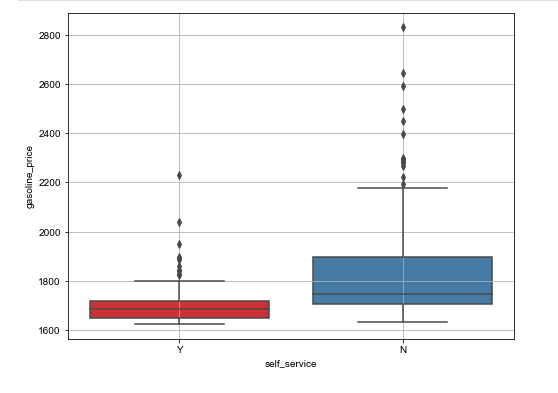

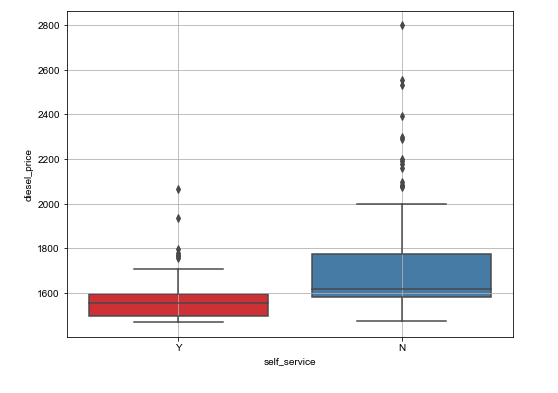

(2) <br>
브랜드별 셀프 주유에 따른 휘발유/경유 가격 막대 그래프에서도 셀프 주유소의 휘발유/경유 가격의 중앙값이 비셀프 주유소의 가격 중앙값보다 더 낮음을 확인했습니다.




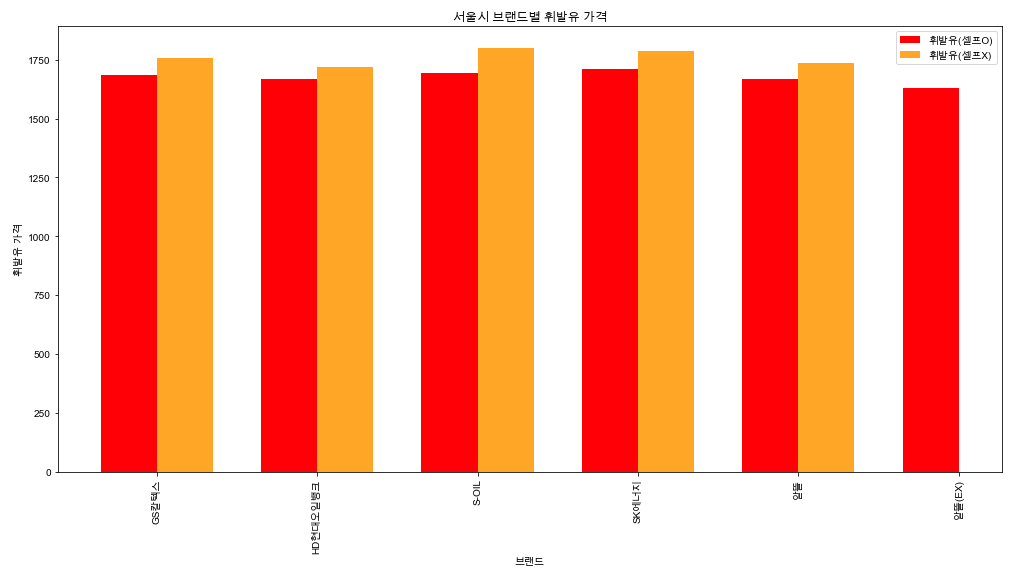

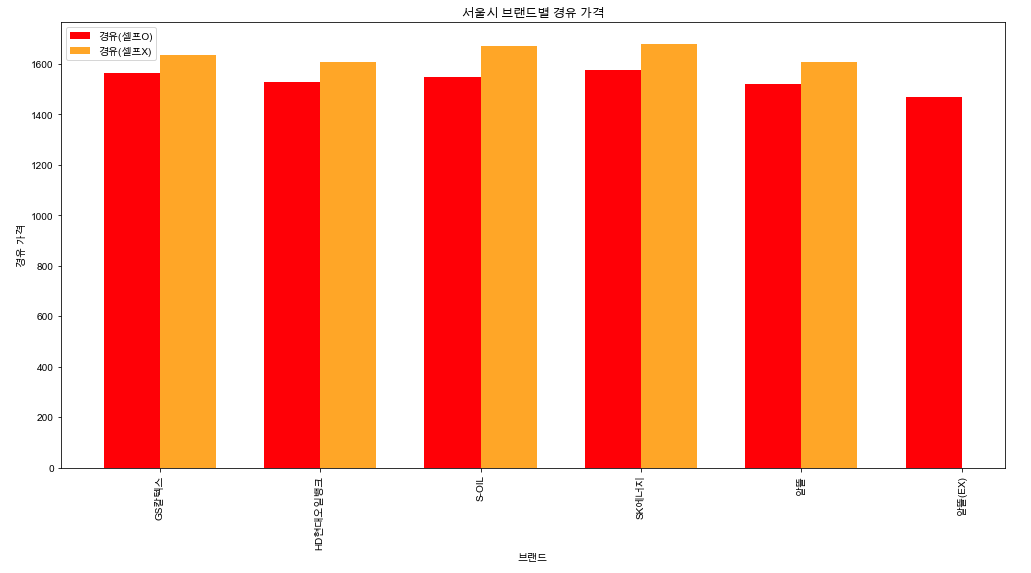

(1), (2)에 따라 <br>
2024년 8월 기준 휘발유와 경유 가격은 셀프 주유소에서 저렴합니다.